<div style="float:left;font-size:20px;">
    <h1>Regression</h1>
</div><div style="float:right;"><img src="../assets/banner.jpg"></div>

Demonstrates regression algorithms, data scaling, cross validation and performance metrics.

<hr>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"R:\Projects\catana")
from catana.plotting import metrics
from catana.plotting.metrics import plot_learning_curves, plot_fit_residual
from catana.plotting.metrics import model_cv

## Metrics

https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics


- metrics.max_error
- metrics.mean_squared_error

In [2]:
# RMSE is the favoured method of loss measurement for Regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Simple regression problem

- Two features
- Noise = 1

In [3]:
from sklearn import datasets
n_samples = 1000
X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=2,
                                      n_informative=2, noise=1, coef=True, random_state=0)

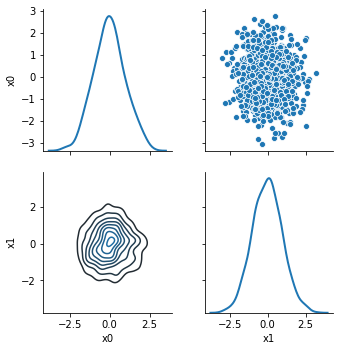

In [4]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({'x0': X[:,0], 'x1': X[:,1], 'y': y})
g = sns.PairGrid(df[['x0', 'x1']], diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B7C296B518>,
      dtype=object)

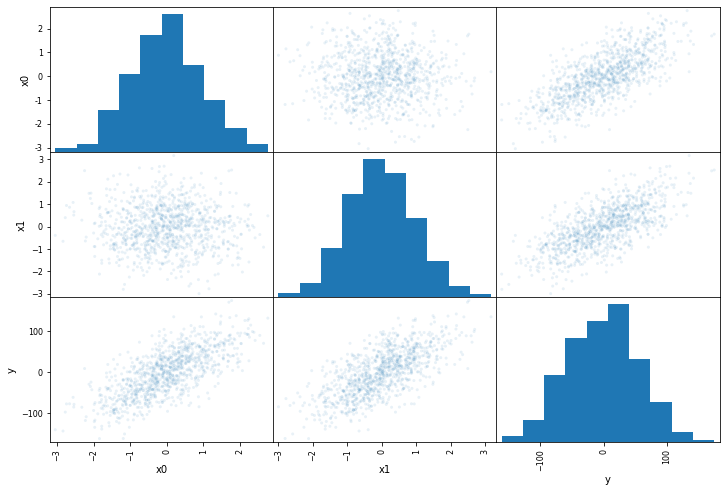

In [5]:
pd.plotting.scatter_matrix(df, figsize=(12, 8), alpha=0.1)

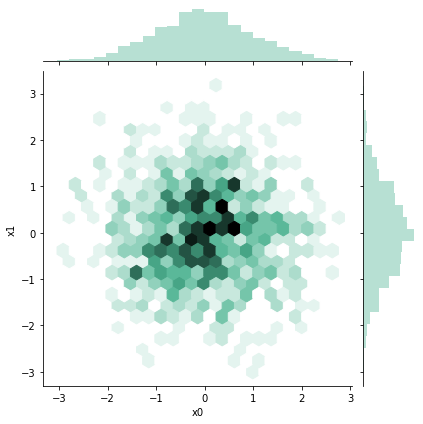

In [6]:
sns.jointplot(df['x0'], df['x1'], kind="hex", color="#4CB391")

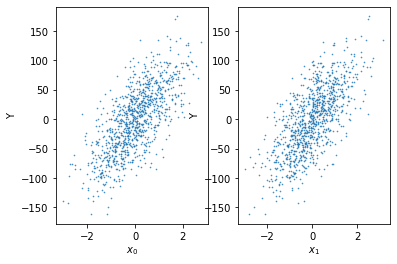

In [7]:
n = X.shape[-1]
f, ax = plt.subplots(1, n)
for i in range(n):
    ax[i].scatter(X[:,i], y, s=0.4, alpha=0.8)
    ax[i].set_xlabel(f'$x_{{{i}}}$');ax[i].set_ylabel('Y');

### Correlations

In [8]:
corr_matrix = df.corr()
corr_matrix

,x0,x1,y
x0,1.000000,-0.013925,0.713314
x1,-0.013925,1.000000,0.690635
y,0.713314,0.690635,1.000000


In [9]:
corr_matrix["y"].sort_values(ascending=False)

y     1.000000
x0    0.713314
x1    0.690635
Name: y, dtype: float64

In [10]:
coef

array([41.09157343, 40.05104636])

In [11]:
# Scale and split into train and test sets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

# Scaling is required for stability in many ML algorithms. 
# The scaler is trained on the training set and used to transform both the train and test sets.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Regression models

## Linear regression models

### Linear regression

- No hyperparameters

In [12]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, lin_reg_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.9825906277373453

In [13]:
# Display parameters
lin_reg.intercept_, lin_reg.coef_

(-1.2730172399325428, array([41.48586882, 39.44967066]))

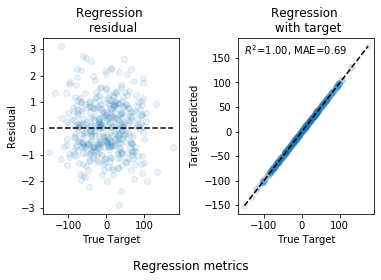

In [14]:
plot_fit_residual(lin_reg, X_train, y_train, X_test, y_test)

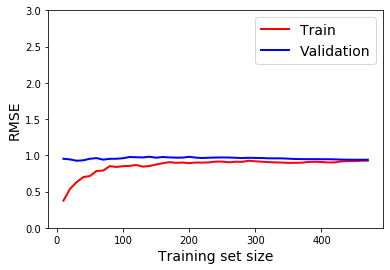

In [15]:
# Linear model shows underfitting
plot_learning_curves(lin_reg, X_train, y_train, m_min=10)

In [16]:
# Evaluate cross-validation error measure
model_cv(lin_reg, X_train, y_train)

neg_mean_squared_error = 0.880 ± 0.167


### Polynomial regression

Hyperparameters: 
- Polynomial degree

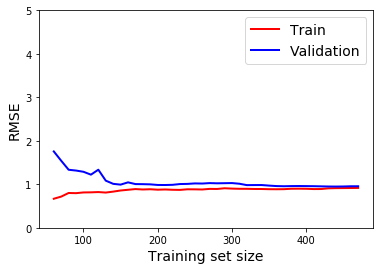

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=4, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

# High order Polynomial model shows overfitting
plot_learning_curves(polynomial_regression, X_train, y_train, m_min=60, rmse_max=5)

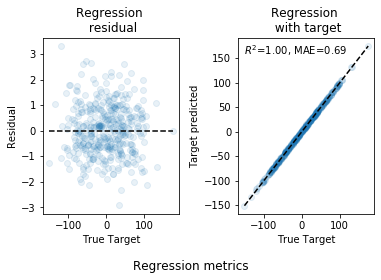

In [18]:
plot_fit_residual(polynomial_regression, X_train, y_train, X_test, y_test)

In [19]:
# Evaluate cross-validation error measure
polynomial_regression_rmse = model_cv(polynomial_regression, X_train, y_train)
polynomial_regression_rmse

neg_mean_squared_error = 0.908 ± 0.190


### Ridge regression

- Hyperparameters: regularisation strength ($\alpha$)

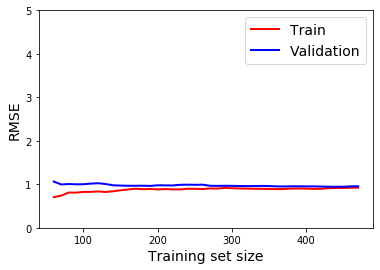

In [20]:
from sklearn.linear_model import Ridge
polynomial_ridge_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
        ("ridge_reg", Ridge(alpha=0.01, tol=1e-3, solver="cholesky", random_state=42)),
    ])

# High order Polynomial model shows overfitting
plot_learning_curves(polynomial_ridge_regression, X_train, y_train, m_min=60, rmse_max=5)

#### Hyperparameter tuning

In [21]:
# Because we are using a pipeline, we need to prefix the model label in the pipe
param_grid = {
    'ridge_reg__alpha': [0.001, 0.025, 0.05, 0.1, 0.5],
}

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(polynomial_ridge_regression, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=-0.908):
{'ridge_reg__alpha': 0.025}


In [22]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge_reg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000800,0.000406,0.000402,0.000492,0.001,{'ridge_reg__alpha': 0.001},-0.944114,-0.815535,-0.854937,-1.039732,...,-0.908364,0.078029,3,-0.846499,-0.880804,-0.871571,-0.834913,-0.864778,-0.859713,0.016738
1,0.000783,0.000394,0.000445,0.000546,0.025,{'ridge_reg__alpha': 0.025},-0.944562,-0.813531,-0.854675,-1.040773,...,-0.908296,0.078912,1,-0.846530,-0.880840,-0.871601,-0.834946,-0.864810,-0.859745,0.016738
2,0.000800,0.000400,0.000275,0.000551,0.05,{'ridge_reg__alpha': 0.05},-0.945083,-0.811569,-0.854452,-1.041939,...,-0.908300,0.079828,2,-0.846623,-0.880946,-0.871694,-0.835046,-0.864906,-0.859843,0.016740
3,0.000605,0.000484,0.000398,0.000488,0.1,{'ridge_reg__alpha': 0.1},-0.946287,-0.808033,-0.854160,-1.044521,...,-0.908537,0.081646,4,-0.846998,-0.881373,-0.872064,-0.835446,-0.865287,-0.860234,0.016745
4,0.000580,0.000475,0.000600,0.000490,0.5,{'ridge_reg__alpha': 0.5},-0.963705,-0.798097,-0.859136,-1.077072,...,-0.921346,0.095147,5,-0.858896,-0.894922,-0.883841,-0.848144,-0.877408,-0.872642,0.016933


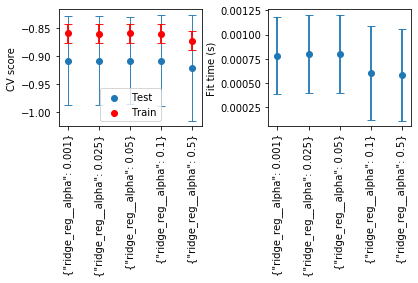

In [23]:
metrics.plot_gridsearch_metrics(grid_search, max_params=10)

#### Tuned model performance

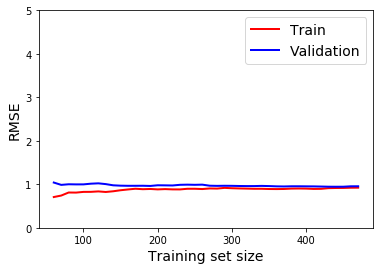

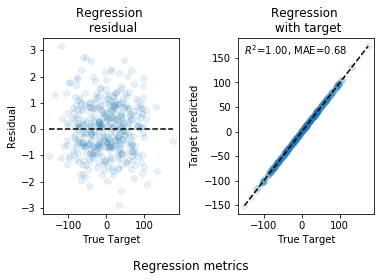

In [24]:
polynomial_ridge_regression = grid_search.best_estimator_
plot_learning_curves(polynomial_ridge_regression, X_train, y_train, m_min=60, rmse_max=5)
plot_fit_residual(polynomial_ridge_regression, X_train, y_train, X_test, y_test)

In [25]:
# Evaluate cross-validation error measure
polynomial_ridge_regression_rmse = model_cv(polynomial_ridge_regression, X_train, y_train)
polynomial_ridge_regression_rmse

neg_mean_squared_error = 0.904 ± 0.194


### Lasso regression

- Hyperparameters: regularisation strength ($\alpha$)

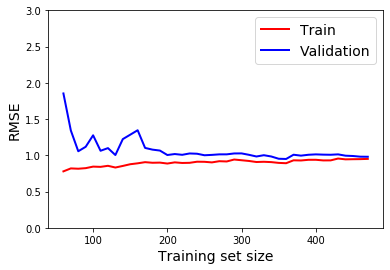

In [26]:
from sklearn.linear_model import Lasso
polynomial_lasso_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lasso_reg", Lasso(alpha=0.1, random_state=42, tol=0.01)),
    ])

# High order Polynomial model shows overfitting
plot_learning_curves(polynomial_lasso_regression, X_train, y_train, m_min=60)

#### Hyperparameter tuning

Best parameter (CV score=-0.974):
{'lasso_reg__alpha': 0.025}


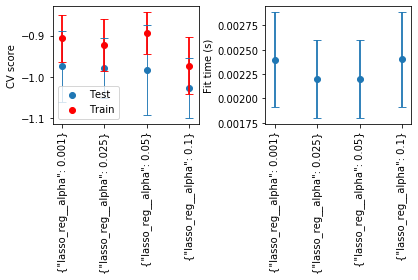

In [27]:
# Because we are using a pipeline, we need to prefix the model label in the pipe
param_grid = {
    'lasso_reg__alpha': [0.001, 0.025, 0.05, 0.1, 0.5],
}

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(polynomial_lasso_regression, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)
metrics.plot_gridsearch_metrics(grid_search, max_params=4)

#### Tuned model performance

neg_mean_squared_error = 1.089 ± 0.610


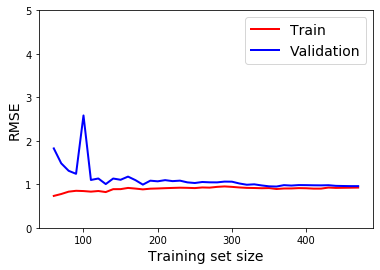

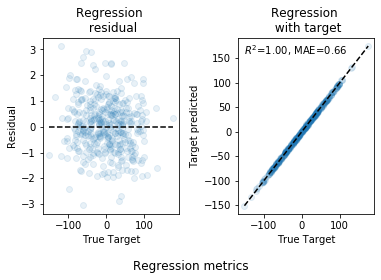

In [28]:
polynomial_lasso_regression = grid_search.best_estimator_
plot_learning_curves(polynomial_lasso_regression, X_train, y_train, m_min=60, rmse_max=5)
plot_fit_residual(polynomial_lasso_regression, X_train, y_train, X_test, y_test)
model_cv(polynomial_lasso_regression, X_train, y_train)

## SVM regression

https://scikit-learn.org/stable/modules/svm.html?highlight=linearsvr#regression
- Complexity: $O(n\times m^{2})-O(n\times m^{3})$ https://scikit-learn.org/stable/modules/svm.html?highlight=linearsvr#complexity
- Avoiding copying data by ensuring the data is C_CONTIGUOUS, you can use the `flags` method to check this is the case, e.g.: `X_train.flags`
- If you have sufficient RAM, you can improve performance by increasing the kernel `cache_size` from default 200 MB to a larger value such as 1000 MB.

### Linear SVM - Linear kernel

Hyperparameters: 
- regularisation hyperparameter ($C$). Default = 1, decreasing value increases degree of regularisation.

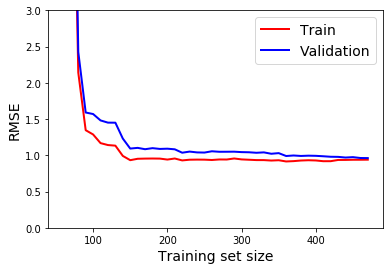

In [29]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=0, random_state=42)
svm_reg.fit(X_train, y_train)
plot_learning_curves(svm_reg, X_train, y_train, m_min=60)

#### Hyperparameter tuning

Best parameter (CV score=-0.882):
{'C': 4}


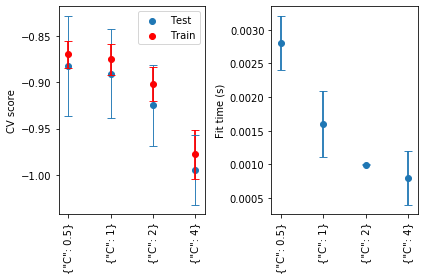

In [30]:
param_grid = {
    'C': [0.5, 1, 2, 4],
}

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)
metrics.plot_gridsearch_metrics(grid_search, max_params=4)

#### Tuned model performance

C:\Users\Mark\.conda\envs\CatAna\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mark\.conda\envs\CatAna\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


neg_mean_squared_error = 0.881 ± 0.166


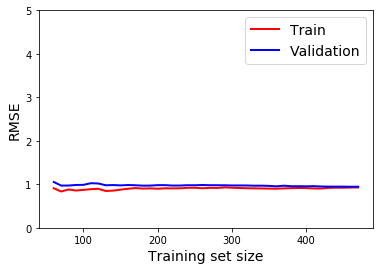

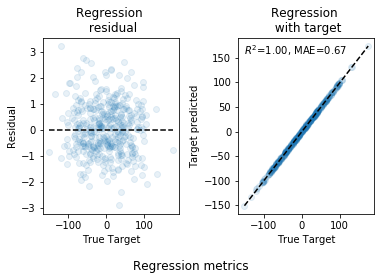

In [31]:
svm_reg = grid_search.best_estimator_
plot_learning_curves(svm_reg, X_train, y_train, m_min=60, rmse_max=5)
plot_fit_residual(svm_reg, X_train, y_train, X_test, y_test)
model_cv(svm_reg, X_train, y_train)

### Linear SVM - Polynomial kernel

Hyperparameters: 
- regularisation hyperparameter ($C$). Default = 1, decreasing value increases degree of regularisation.
- $\gamma$ defines how much influence each training example has, the larger $\gamma$ the smaller the range of influence. `'auto'` = $\frac{1}{n}$.

It is recommended to gridsearch in orders of 10 to find the optimal configuration for these parameters.

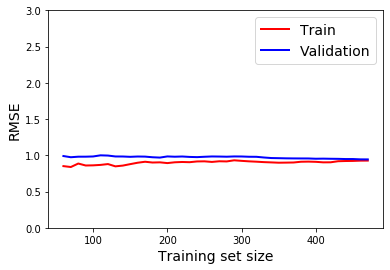

In [32]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=1, C=10, gamma='auto')
svm_poly_reg.fit(X_train, y_train)
plot_learning_curves(svm_poly_reg, X_train, y_train, m_min=60)

#### Hyperparameter tuning

In [33]:
grid_search.cv_results_['params']

[{'C': 0.5}, {'C': 1}, {'C': 2}, {'C': 4}]

Best parameter (CV score=-0.884):
{'C': 10.0, 'gamma': 1}


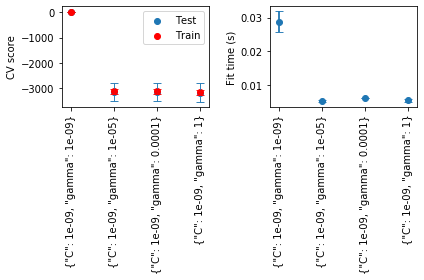

In [34]:
param_grid = {
        'C': [1e-9, 1e-5, 1e-3, 1e1],
    'gamma': [1e-9, 1e-5, 1e-4, 1],
    #'degree': [1, 2]
}

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(svm_poly_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)
metrics.plot_gridsearch_metrics(grid_search, max_params=4)

#### Tuned model performance

neg_mean_squared_error = 0.886 ± 0.168


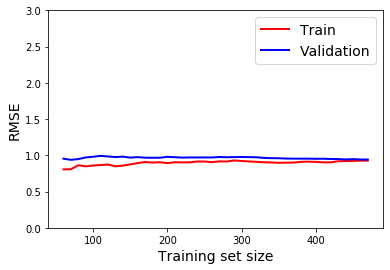

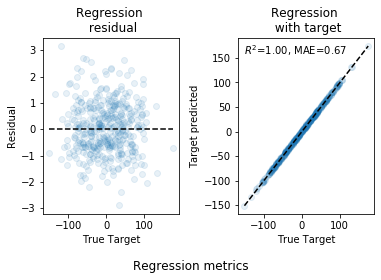

In [35]:
svm_poly_reg = grid_search.best_estimator_
plot_learning_curves(svm_poly_reg, X_train, y_train, m_min=60)
plot_fit_residual(svm_poly_reg, X_train, y_train, X_test, y_test)
model_cv(svm_poly_reg, X_train, y_train)

### Linear SVM - RBF kernel

Hyperparameters: 
- regularisation hyperparameter ($C$). Default = 1, decreasing value increases degree of regularisation.
- $\gamma$ defines how much influence each training example has, the larger $\gamma$ the smaller the range of influence. `'auto'` = $\frac{1}{n}$.

It is recommended to gridsearch in orders of 10 to find the optimal configuration for these parameters.

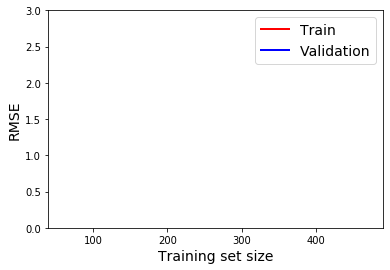

In [36]:
from sklearn.svm import SVR
svm_rbf_reg = SVR(kernel="rbf", degree=1, C=10, gamma='auto')
svm_rbf_reg.fit(X_train, y_train)
plot_learning_curves(svm_rbf_reg, X_train, y_train, m_min=60)

#### Hyperparameter tuning

Best parameter (CV score=-3184.632):
{'C': 0.01, 'gamma': 0.001}


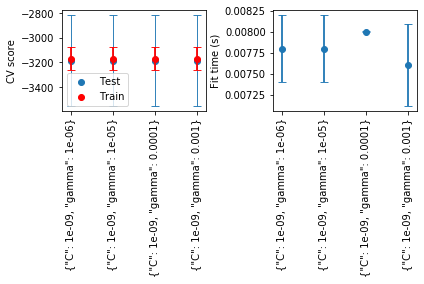

In [37]:
param_grid = {
    'C': [1e-9, 1e-4, 1e-3, 1e-2],
    'gamma': [1e-6, 1e-5, 1e-4, 1e-3],
}

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(svm_rbf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)
metrics.plot_gridsearch_metrics(grid_search, max_params=4)

## Decision tree

Hyperparameters: 

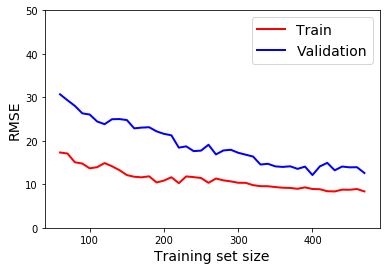

In [38]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(min_samples_leaf=5)
tree_reg.fit(X_train, y_train)
plot_learning_curves(tree_reg, X_train, y_train, m_min=60, rmse_max=50)

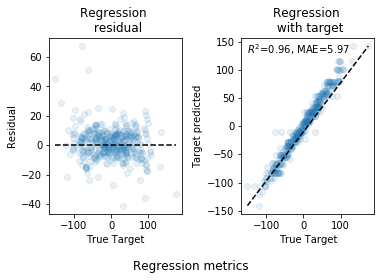

In [39]:
plot_fit_residual(tree_reg, X_train, y_train, X_test, y_test)

In [40]:
"""
# This is only useful for classification
# Convert to png in cmd with: dot -Tpng pseudo_data_tree.dot -o pseudo_data_tree.png
from sklearn.tree import export_graphviz
export_graphviz(
tree_reg,
out_file="C:/Temp/pseudo_data_tree.dot",
feature_names=['x1'],
class_names=['y'],
rounded=True,
filled=True
)
"""

'\n# This is only useful for classification\n# Convert to png in cmd with: dot -Tpng pseudo_data_tree.dot -o pseudo_data_tree.png\nfrom sklearn.tree import export_graphviz\nexport_graphviz(\ntree_reg,\nout_file="C:/Temp/pseudo_data_tree.dot",\nfeature_names=[\'x1\'],\nclass_names=[\'y\'],\nrounded=True,\nfilled=True\n)\n'

## Ensemble methods


### Random Forest

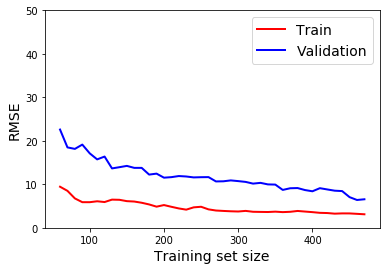

In [41]:
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
random_forest_reg.fit(X_train, y_train)
plot_learning_curves(random_forest_reg, X_train, y_train, m_min=60, rmse_max=50)

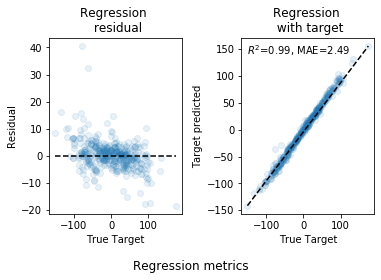

In [42]:
plot_fit_residual(random_forest_reg, X_train, y_train, X_test, y_test)

### Adaboost

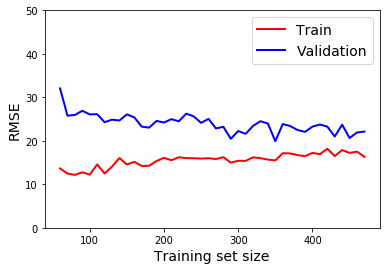

In [43]:
from sklearn.ensemble import AdaBoostRegressor
ada_reg = AdaBoostRegressor(random_state=0, n_estimators=10)
ada_reg.fit(X_train, y_train)
plot_learning_curves(ada_reg, X_train, y_train, m_min=60, rmse_max=50)

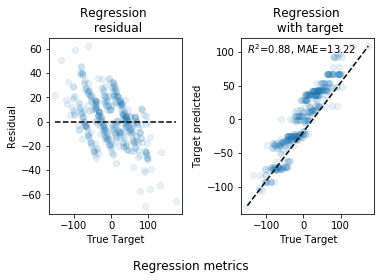

In [44]:
plot_fit_residual(ada_reg, X_train, y_train, X_test, y_test)

### Gradient boost

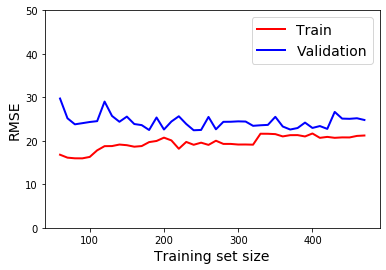

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)
plot_learning_curves(gbrt, X_train, y_train, m_min=60, rmse_max=50)

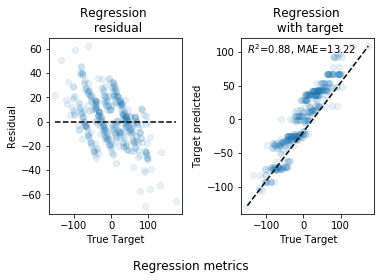

In [46]:
plot_fit_residual(ada_reg, X_train, y_train, X_test, y_test)

### XGBoost

Currently the best in class ensemble learning method. Faster than gradient boosting, more memory efficient and parallisable. Many leading algorithms use XGBoost.

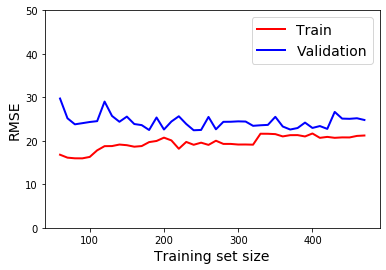

In [47]:
import xgboost
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
plot_learning_curves(gbrt, X_train, y_train, m_min=60, rmse_max=50)

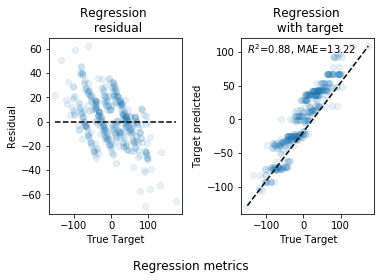

In [48]:
plot_fit_residual(ada_reg, X_train, y_train, X_test, y_test)

## Neural network

In [34]:
# Loss function: For regression problems, the mean squared error (MSE) function is commonly used.
# Here the Adam Optimizer is used, which is one of the current default optimizers in deep learning development.
# Adam stands for “Adaptive Moment Estimation” and can be considered as a combination between two other popular
# optimizers AdaGrad and RMSProp.
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [37]:
# cd /d R:\Projects\JupyterNotebooks\Analysis\Graph
# tensorboard --logdir=R:\Projects\JupyterNotebooks\Analysis\Graph\

In [49]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

epochs = 10
batch_size = 256
lr = 0.001 * 10
verbose_flag = [0, 1, 2][1]
validation_split = 0.2  # Fraction of the training data to be used as validation data.

model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(1, activation='linear'))
optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mse"])


tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,
                         write_graph=True, write_images=True)


callbacks_list = [tbCallBack]

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    verbose=verbose_flag, validation_split=validation_split,
                    callbacks=callbacks_list)

Using TensorFlow backend.





Train on 480 samples, validate on 120 samples







Epoch 1/10
480/480 [==============================] - 0s 674us/step - loss: 3219.5903 - mean_squared_error: 3219.5903 - val_loss: 2932.3154 - val_mean_squared_error: 2932.3154

Epoch 2/10
480/480 [==============================] - 0s 15us/step - loss: 3214.3545 - mean_squared_error: 3214.3545 - val_loss: 2928.5837 - val_mean_squared_error: 2928.5837
Epoch 3/10
480/480 [==============================] - 0s 10us/step - loss: 3208.3676 - mean_squared_error: 3208.3676 - val_loss: 2924.6997 - val_mean_squared_error: 2924.6997
Epoch 4/10
480/480 [==============================] - 0s 15us/step - loss: 3202.4697 - mean_squared_error: 3202.4697 - val_loss: 2920.5339 - val_mean_squared_error: 2920.5339
Epoch 5/10
480/480 [==============================] - 0s 13us/step - loss: 3196.4095 - mean_squared_error: 3196.4095 - val_loss: 2916.1870 - val_mean_squared_error: 2916.1870
Epoch 6/10
480/480 [==============================] - 0s 10us/step 

In [50]:
keras.backend.clear_session()

random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10)

NameError: name 'random' is not defined

## Optimising hyperparameters

## Comparing algorithms